# Sommaire

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from exploration import * # Fichier de fonctions
import pickle

import datetime as dt

In [110]:
PATH_DATA = "/Users/alexandremonod/Python/OC_ML/projet_3_anticiper_consommation_ges_seattle/data/"
raw = pd.read_csv(f'{PATH_DATA}2016_Building_Energy_Benchmarking.csv')

## Nettoyage des données

In [111]:
analyse_forme(raw)

+----+----------+-------------+---------------+------------+----------------+
|    |   Taille |   Nb lignes |   Nb colonnes |   % de NaN |   Nb duplicats |
|----+----------+-------------+---------------+------------+----------------|
|  0 |   155296 |        3376 |            46 |      12.85 |              0 |
+----+----------+-------------+---------------+------------+----------------+


J'ai environ 13% de NaN, pas de duplicats, le dataset est assez propre.

In [112]:
raw.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

### Choix des variables à prédire

La consommation d'énergie et les émissions de CO2 sont représentées par des variables gloables et des variables ramenées à l'unité de surface (pied carré). Nous décions de poursuivre l'étude sur les variables globales. 
De plus la consommation d'énergie dispose également d'une variable normalisée par les conditions météorologiques. Nous utilisons cette dernières pour les travaux afin d'éviter des variations liées à la météo. 

Nous utiliserons donc:
- Pour la consommation d'énergie: SiteEnergyUseWN(kBtu)
- Pour les émissions de CO2: TotalGHGEmissions

In [113]:
drop_cols = [
            "SiteEnergyUse(kBtu)", 
            "GHGEmissionsIntensity",
            ]

raw.drop(axis=1, columns=drop_cols, inplace=True)

In [114]:
def test_completion(data):
    """
    Compute sorted completion rate and number of missing values for each variable of the argument in a descending order
    
    Args:
        data(dataset) : A dataset with variables
        
    Returns:
        A specific dataframe with completion rate for each variable. 
        Schema :
            Index(string): Variable names
            Taux de completion(float): completion rate
            Nombre de valeurs manquantes(int): Number of missing values
    """
    var_dict = {}
    
    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["Taux de complétion", "Nombre de valeurs manquantes"]).sort_values(by="Taux de complétion", ascending=False)

test_completion(raw)

,Taux de complétion,Nombre de valeurs manquantes
OSEBuildingID,100.00,0
DataYear,100.00,0
PropertyGFABuilding(s),100.00,0
PropertyGFAParking,100.00,0
PropertyGFATotal,100.00,0
NumberofFloors,100.00,0
YearBuilt,100.00,0
Longitude,100.00,0
Latitude,100.00,0
Neighborhood,100.00,0


En croisant les résultats avec l'étude de la [nomenclature](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy) des variables, nous en écartons certaines:
- "YearsENERGYSTARCertified": Années où le batiment à reçu une certification ENERGYSTAR
- "Comments": divers commentaires
- "DataYear": Année du relevé. Toutes les observations ont une valeur égale.

In [115]:
drop_cols = [
            "YearsENERGYSTARCertified",
            "Comments",
            "DataYear"
            ]

raw.drop(axis=1, columns=drop_cols, inplace=True)

### Valeurs à prédire à zéro et valeurs à prédire manquantes.

Afin de poursuivre le filtrage des observations, nous étudions celles ou les variables à prédire sont à 0 ou manquantes.

In [116]:
to_predict_zero = raw[(raw["SiteEnergyUseWN(kBtu)"] == 0) | (raw["TotalGHGEmissions"] == 0)]
to_predict_na = raw[(raw["SiteEnergyUseWN(kBtu)"].isna()) | (raw["TotalGHGEmissions"].isna())]
print(f"Nombre d'observations où les variables à prédire sont à zéro: {to_predict_zero.shape[0]}\n")
display(to_predict_zero.head(5))
print(f"Nombre d'observations où les variables à prédire sont manquantes: {to_predict_na.shape[0]}\n")
display(to_predict_na.head(5))

Nombre d'observations où les variables à prédire sont à zéro: 31



,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions
28,34,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090,3,...,0.0,0.0,0.0000,0.0,0.0,0.0,False,Missing Data,NaN,0.00
31,37,SPS-District K-12,K-12 School,John Hay Elementary,201 Garfield St.,Seattle,WA,98109.0,0809000005,7,...,0.0,0.0,438691.6875,1496816.0,0.0,0.0,False,Missing Data,NaN,10.43
62,87,SPS-District K-12,K-12 School,Arbor Heights Elementary,3701 S.W. 104th St.,Seattle,WA,98146.0,2518400005,1,...,0.0,0.0,176088.0938,600813.0,0.0,0.0,False,Missing Data,NaN,4.19
81,118,SPS-District K-12,K-12 School,Pathfinder K-8,1901 SW Genesee St.,Seattle,WA,98106.0,1324039116,1,...,0.0,0.0,497706.8125,1698176.0,0.0,0.0,False,Missing Data,NaN,11.84
85,122,SPS-District K-12,K-12 School,John Muir Elementary,3301 S. Horton St.,Seattle,WA,98144.0,1524049002,2,...,0.0,0.0,687906.8750,2347138.0,0.0,0.0,False,Missing Data,NaN,16.36


Nombre d'observations où les variables à prédire sont manquantes: 10



,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions
563,757,NonResidential,Large Office,Market Place I & II-2003 Western Avenue,2003 Western Avenue,Seattle,WA,98121.0,1977200280,7,...,NaN,0.0,1427645.25,4871126.0,14160.40918,1416041.0,False,Compliant,NaN,109.16
578,773,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,215 COLUMBIA ST,Seattle,WA,98104.0,0939000245,7,...,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN
758,19798,Multifamily LR (1-4),Low-Rise Multifamily,SANDHURST APTS,7239 SAND POINT WAY NE,Seattle,WA,98115.0,0225049032,4,...,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN
1768,23355,Multifamily LR (1-4),Low-Rise Multifamily,GRAHAM VIEW,6040 CALIFORNIA AVE SW,Seattle,WA,98136.0,7625703280,1,...,593798.625,NaN,NaN,NaN,NaN,NaN,False,Compliant,NaN,NaN
1792,23437,Multifamily LR (1-4),Low-Rise Multifamily,MERCER CREST APT,500 W MERCER ST,Seattle,WA,98119.0,3876900230,7,...,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN


Le nombre étant restreint, nous décidons de les supprimer.

In [117]:
idx_zero = set(to_predict_zero.index)
idx_na = set(to_predict_na.index)
idx_to_drop = idx_zero | idx_na
raw.drop(axis = 0, index=idx_to_drop, inplace = True)
print(f"Nombre d'observations restantes: {raw.shape[0]}")

Nombre d'observations restantes: 3335


### Valeurs aberrantes

#### Etude de la variable Outlier

Dans les données une variable est explicitement désignée comme "Outlier". Regardons les différentes modalités que peut prendre la variable.

In [118]:
raw["Outlier"].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

Vraissemblalement la varibale qualifie les valeurs aberrantes selon qu'elles soient hautes ou basses. Les observations où la variable n'est pas renseignée corresponderaient aux observations qui n'ont pas été considérées comme aberrantes lors des relevés. Regradons les populations pour chaques modalité.

In [119]:
num_hight_outliers = raw[raw["Outlier"] == "High outlier"]
num_low_outliers = raw[raw["Outlier"] == "Low outlier"]
num_non_outliers = raw[raw["Outlier"].isna()]

print(f"Nombre d'observations aberrantes hautes: {num_hight_outliers.shape[0]}")
print(f"Nombre d'observations aberrantes basses: {num_low_outliers.shape[0]}")
print(f"Nombre d'observations non aberrantes: {num_non_outliers.shape[0]}\n")

Nombre d'observations aberrantes hautes: 9
Nombre d'observations aberrantes hautes: 23
Nombre d'observations non aberrantes: 3303



Nous supprimons l'ensemble des observations considérées comme aberrantes. Après celà nous supprimons aussi la variable qui n'a plus d'intérêt après le filtrage.

In [120]:
all_outliers = set(num_hight_outliers.index) | set(num_low_outliers.index)
raw.drop(index= all_outliers, columns="Outlier", inplace=True)
print(f"Nombre d'observations restantes: {raw.shape[0]}")

Nombre d'observations restantes: 3303


#### Observations où la surface l'activité principale est supérieure à la surface totale

Certains observations ont une valeur variable LargestPropertyUseTypeGFA supérieure à celle de la variable PropertyGFATotal. Observons le phénomène.

In [121]:
cols = [
        "YearBuilt",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
        "NumberofBuildings",
        "NumberofFloors",
        "PropertyGFATotal", 
        "PropertyGFAParking", 
        "PropertyGFABuilding(s)",
        "LargestPropertyUseTypeGFA",
        "SecondLargestPropertyUseTypeGFA",
        "ThirdLargestPropertyUseTypeGFA",
        "SiteEUIWN(kBtu/sf)",
]
# Je supprime les lignes qui ont un écart > 10%
raw["pourcentage_surface_gfa"] = (raw["LargestPropertyUseTypeGFA"] - raw["PropertyGFATotal"]) / raw["PropertyGFATotal"]
possible_outliers = raw[raw["pourcentage_surface_gfa"] > 0.1].loc[:,cols]
print("10 premières observations où la surface de l'activité principale est supérieure à la surface totale du bâtiment")
display(possible_outliers.head(10))
print(f"Nombre d'observations où la surface d'activité principale est supérieure à la surface totale: {possible_outliers.shape[0]}")

10 premières observations où la surface de l'activité principale est supérieure à la surface totale du bâtiment


,YearBuilt,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf)
35,1992,Office,Laboratory,Non-Refrigerated Warehouse,1.0,3,494835,0,494835,757027.0,639931.0,459748.0,233.100006
59,1922,Senior Care Community,Parking,NaN,1.0,5,217603,0,217603,296313.0,0.0,NaN,153.699997
66,1929,Retail Store,NaN,NaN,1.0,2,58320,0,58320,72072.0,NaN,NaN,17.200001
74,1928,Other,NaN,NaN,1.0,1,60696,0,60696,108000.0,NaN,NaN,8.100000
75,1928,Other,NaN,NaN,1.0,2,262048,0,262048,296000.0,NaN,NaN,70.300003
170,2000,Hospital (General Medical & Surgical),Parking,NaN,9.0,8,1158691,0,1158691,1350182.0,387651.0,NaN,219.699997
261,1976,Office,Parking,Restaurant,1.0,42,635824,0,635824,718473.0,40000.0,19671.0,62.900002
359,1999,Non-Refrigerated Warehouse,NaN,NaN,1.0,1,243044,0,243044,325424.0,NaN,NaN,4.300000
364,1964,Strip Mall,Parking,NaN,6.0,1,111900,0,111900,124231.0,0.0,NaN,81.099998
398,1980,Distribution Center,NaN,NaN,1.0,1,52613,0,52613,59504.0,NaN,NaN,20.700001


Nombre d'observations où la surface d'activité principale est supérieure à la surface totale: 132


A défaut de pouvoir trouver une explication dans les autres variable, nous décidons de supprimer ces observations.  
Puis je supprime cette variable.

In [122]:
# Je supprime les lignes qui ont un écart > 10%
raw.drop(index=possible_outliers.index, inplace=True)
print(f"Observations restantes: {raw.shape[0]}")
raw.drop(columns= "pourcentage_surface_gfa", inplace=True)

Observations restantes: 3171


#### Observation où le nombre d'étages est aberrant

<AxesSubplot:>

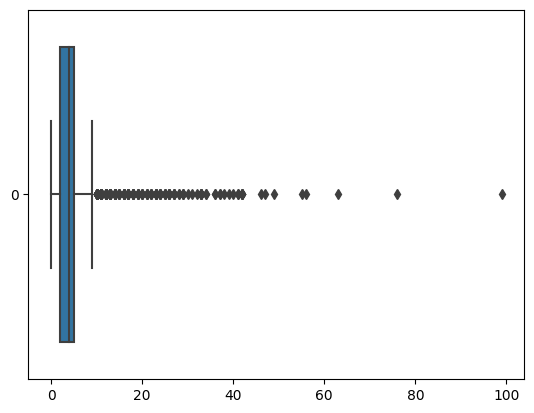

In [123]:
#plt.figure.figsize(6,3)
sns.boxplot(raw["NumberofFloors"], orient="h")

On observe un étalement des données à partir de la valeur 42. Visualisons les données qui ont des valeur égales ou supérieures à ce seuil.

In [124]:
display(raw[raw["NumberofFloors"]>=42].sort_values("NumberofFloors", ascending=False))
print(f"Mediane de la variable PopertyGFATotal: {raw['PropertyGFATotal'].median()}")
print(f"Mediane de la variable SiteEnergyUseWN(kBtu): {raw['SiteEnergyUseWN(kBtu)'].median()}")
print(f"Mediane de la variable TotalGHGEmissions: {raw['TotalGHGEmissions'].median()}")

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,...,SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions
1359,21611,NonResidential,Worship Facility,Seattle Chinese Baptist Church,5801 Beacon Avenue South,Seattle,WA,98108.0,2124049098,2,...,46.599998,3.260012e+05,0.000000e+00,9.554550e+04,326001.0,0.000000,0.0,False,Compliant,2.27
559,775,NonResidential,Large Office,Columbia Center - 2015,701 5th Avenue,Seattle,WA,98104.0,0942000640,7,...,166.500000,9.253726e+07,0.000000e+00,2.574791e+07,87851862.0,50857.632810,5085763.0,False,Compliant,882.56
233,357,Nonresidential COS,Large Office,Seattle Municipal Tower (2030),700 Fifth Avenue,Seattle,WA,98104.0,0942000720,3,...,158.100006,6.157618e+07,0.000000e+00,1.804695e+07,61576180.0,0.000000,0.0,False,Compliant,429.27
292,422,NonResidential,Large Office,Two Union Square,601 Union St.,Seattle,WA,98101.0,1976700125,7,...,113.300003,5.098450e+07,9.156549e+05,1.350581e+07,46081813.0,25202.298830,2520230.0,False,Compliant,525.78
271,399,NonResidential,Large Office,1201 Third Avenue,1201 3rd ave,Seattle,WA,98101.0,1974700120,7,...,145.300003,5.514030e+07,2.179488e+06,1.449966e+07,49472833.0,14268.400390,1426840.0,False,Compliant,588.90
229,353,NonResidential,Large Office,Safeco Plaza,1001 Fourth Avenue,Seattle,WA,98154.0,0942000300,7,...,154.699997,4.751812e+07,0.000000e+00,1.124821e+07,38378889.0,67844.148440,6784415.0,False,Compliant,627.87
221,345,NonResidential,Large Office,999 Third Avenue,"999 3rd Avenue, Suite 1550",Seattle,WA,98104.0,0939000435,7,...,133.500000,4.468366e+07,0.000000e+00,1.304861e+07,44521844.0,1618.117065,161812.0,False,Compliant,318.97
273,402,NonResidential,Large Office,US Bank Centre,1420 5th Avenue,Seattle,WA,98101.0,1975700080,7,...,162.699997,5.850684e+07,0.000000e+00,1.572921e+07,53668061.0,29380.699220,2938070.0,False,Compliant,530.18
231,355,NonResidential,Large Office,901 Fifth Avenue,901 Fifth Avenue,Seattle,WA,98164.0,0942000365,7,...,372.000000,7.156895e+07,8.829835e+05,2.011630e+07,68636822.0,0.000000,0.0,False,Compliant,546.65
256,383,NonResidential,Large Office,Smith Tower,506 Second Avenue,Seattle,WA,98104.0,0939000060,7,...,189.100006,2.488099e+07,1.014422e+06,3.294180e+06,11239744.0,110080.773400,11008077.0,False,Compliant,741.30


Mediane de la variable PopertyGFATotal: 44098.0
Mediane de la variable SiteEnergyUseWN(kBtu): 1914443.25
Mediane de la variable TotalGHGEmissions: 33.8


Nous constatons que l'observation avec 99 étage a une surface et des indicateurs de consommation d'énergie et d'émission de CO2 très inférieurs à la médiane de ces variables. On peut en déduire que l'observation est aberrrante.  
Les autres observations ont des valeurs bien supérieures aux médianes observées. Nous ne pouvons donc pas les considérer comme aberrante.

In [125]:
raw.drop(index=1359, inplace=True)
print(f"Nombre d'observations restantes: {raw.shape[0]}")

Nombre d'observations restantes: 3170


In [126]:
raw.BuildingType.unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [127]:
raw.head(5).T

,0,1,2,3,4
OSEBuildingID,1,2,3,5,8
BuildingType,NonResidential,NonResidential,NonResidential,NonResidential,NonResidential
PrimaryPropertyType,Hotel,Hotel,Hotel,Hotel,Hotel
PropertyName,Mayflower park hotel,Paramount Hotel,5673-The Westin Seattle,HOTEL MAX,WARWICK SEATTLE HOTEL (ID8)
Address,405 Olive way,724 Pine street,1900 5th Avenue,620 STEWART ST,401 LENORA ST
City,Seattle,Seattle,Seattle,Seattle,Seattle
State,WA,WA,WA,WA,WA
ZipCode,98101.0,98101.0,98101.0,98101.0,98121.0
TaxParcelIdentificationNumber,0659000030,0659000220,0659000475,0659000640,0659000970
CouncilDistrictCode,7,7,7,7,7


### Sélection des bâtiments non destinées à l'habitation

Suppression des bâtiments destinés à l'habitation. 

In [128]:
non_residential_types = ["NonResidential"
                        , 'Nonresidential COS'
                        , 'Nonresidential WA'
]

raw = raw[raw["BuildingType"].isin(non_residential_types)]

### Suppression des variables non pertinentes pour l'analyse

On cherche à prédire une consommation électrique.  
On n'a pas besoin des variables géographiques, sauf Neigborhood et CouncilDistrictCode, car on reste à Seattle.  
On supprime les données de consommation hormis les variables énergétiques.

In [129]:
drop_cols = ['SiteEUI(kBtu/sf)'
              ,'SiteEUIWN(kBtu/sf)'
              ,'SourceEUI(kBtu/sf)'
              ,'SourceEUIWN(kBtu/sf)'
              ,'SteamUse(kBtu)'
              ,'Electricity(kWh)'
              ,'Electricity(kBtu)'
              ,'NaturalGas(therms)'
              ,'NaturalGas(kBtu)'
              ,'PropertyName'
              ,'Address'
              , 'City'
              , 'State'
              , 'ZipCode'
              , 'TaxParcelIdentificationNumber'
       ]

raw.drop(columns=drop_cols, inplace=True)

### Variables ComplianceStatus et DefaultData

Les deux variables ComplianceStatus et DefaultData ne sont pas détaillées dans la [nomenclature](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy) des données. 
Afin de vérifier si nous les conservons, nous regardons le nombre d'observations par modalité et la distribution des variables à prédires pour chacune de leurs modalités.

Commençons par ComplianceStatus.

In [130]:
raw.ComplianceStatus.value_counts()

Compliant                       1428
Error - Correct Default Data      12
Name: ComplianceStatus, dtype: int64

Quelques observations donnent le message "Error - Correct Default Data". Comme elles sont peu nombreuses et peut-être porteuses d'une erreur, je les supprime.

In [131]:
raw = raw[raw.ComplianceStatus == "Compliant"]
raw.drop(columns="ComplianceStatus", inplace=True)
print(f"Nombre de variable restantes après la suppresion de la variable ComplianceStatus {raw.shape[1]}")

Nombre de variable restantes après la suppresion de la variable ComplianceStatus 24


Observons maintenant la variable DefaultData.

In [132]:
raw['DefaultData'].unique()

array([False])

On n'observe qu'une seule modalité de DefaultData.  
On supprime donc la colonne.

In [133]:
raw.drop(columns = "DefaultData", inplace=True)
print(f"Nombre de variables restantes {raw.shape[1]}")

Nombre de variables restantes 23


### Filtrage des variables explicatives fortement corrélées entre elles

Nous commençons par observer largement la distribution de toutes les variable quantitatives restantes.

In [134]:
#sns.pairplot(raw)

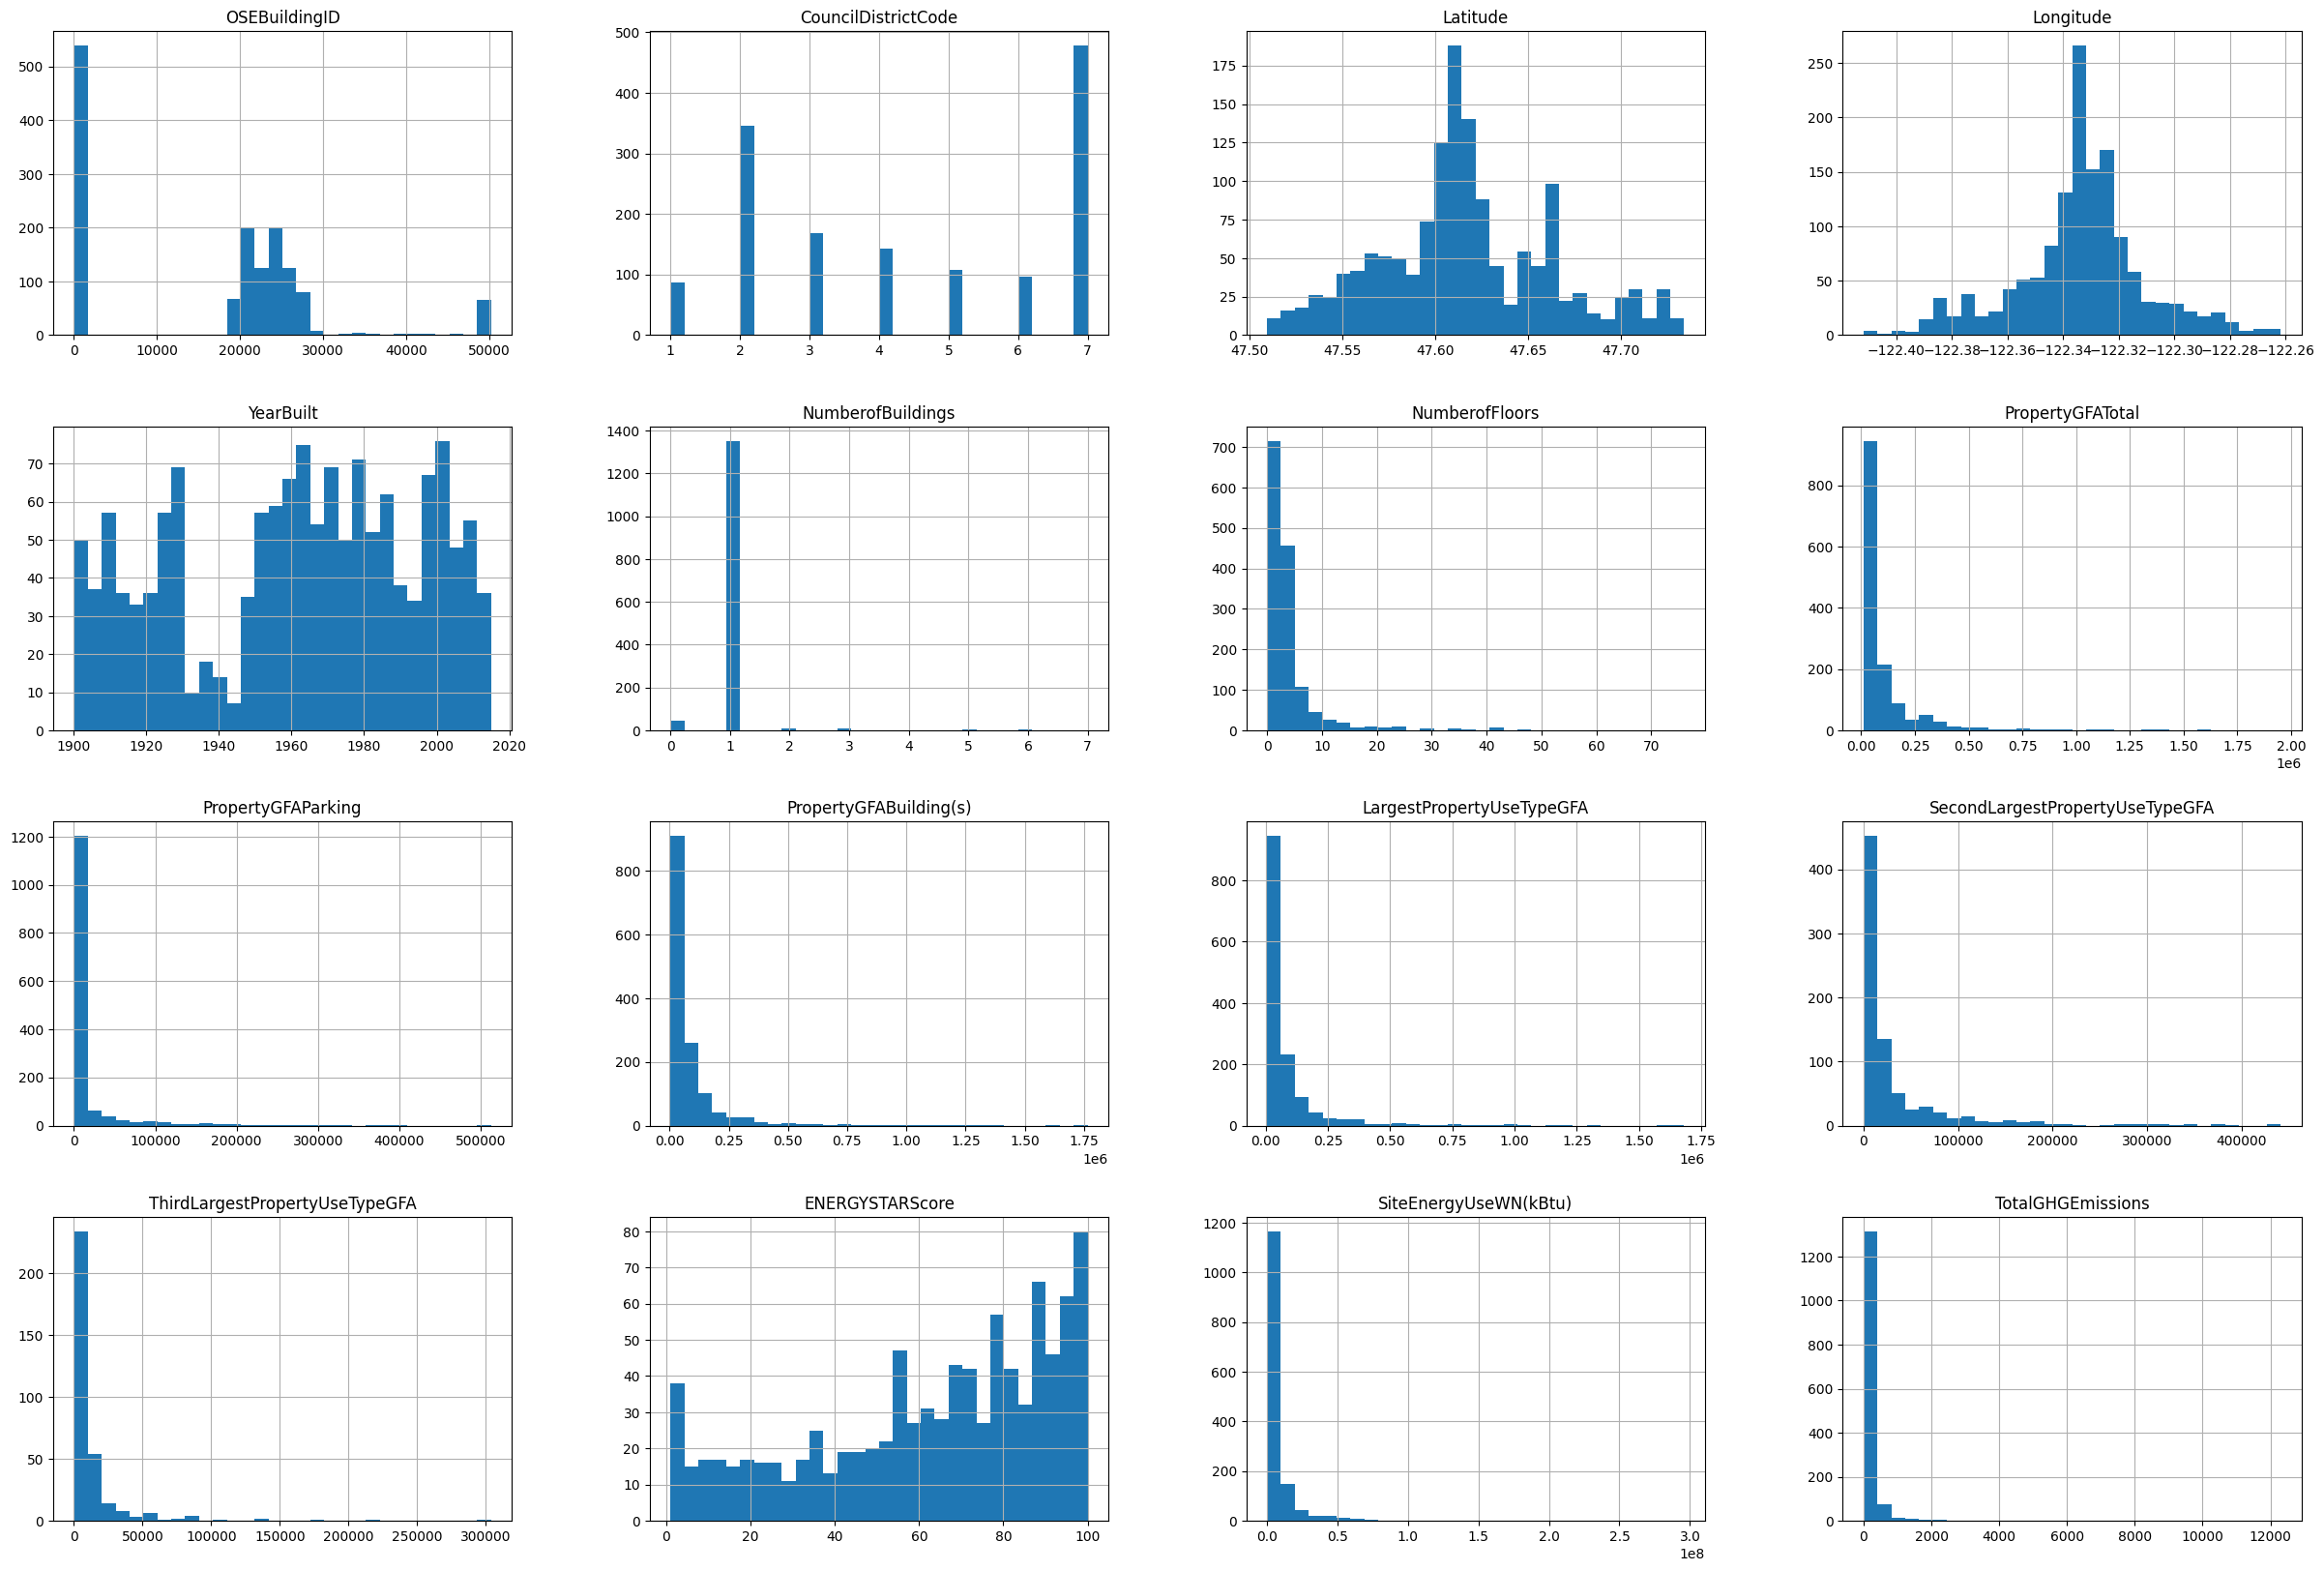

In [135]:
raw.hist(bins=30, figsize=(30, 20))
plt.show()

Nous pouvons d'ores et déjà faire plusieurs constats:

 - NumberofBuildings et pourcentage_surface_gfa ont une modalité très majoritaire
 - La Latitude et la Longitude semblent suivre une courbe gaussienne
 
 - Une majorité de varibale ont une distribution concentrée autour des valeurs faibles. Parmi celles-ci:
     - Les variables de surface des sites (incluant GFA)
     - Les variables de consommation des sites


- Plusieurs séries de variables semblent avoir des comportement de distribution proches. Parmi celles-ci:
    - Les variables sur les surfaces.
    - Les deux variables cibles (SIteEnergyUse et TotalGHGEmissions)

Observons les corrélations entre les variables.

Les deux variables cibles ont une distribution asymétrique.  
Il faudra appliquer une transformation pour réduire l'effet de taille. Les valeurs éloignées peuvent avoir des effets indésirables. Une transformation simple est le log.
log(x) ou log(1+x)

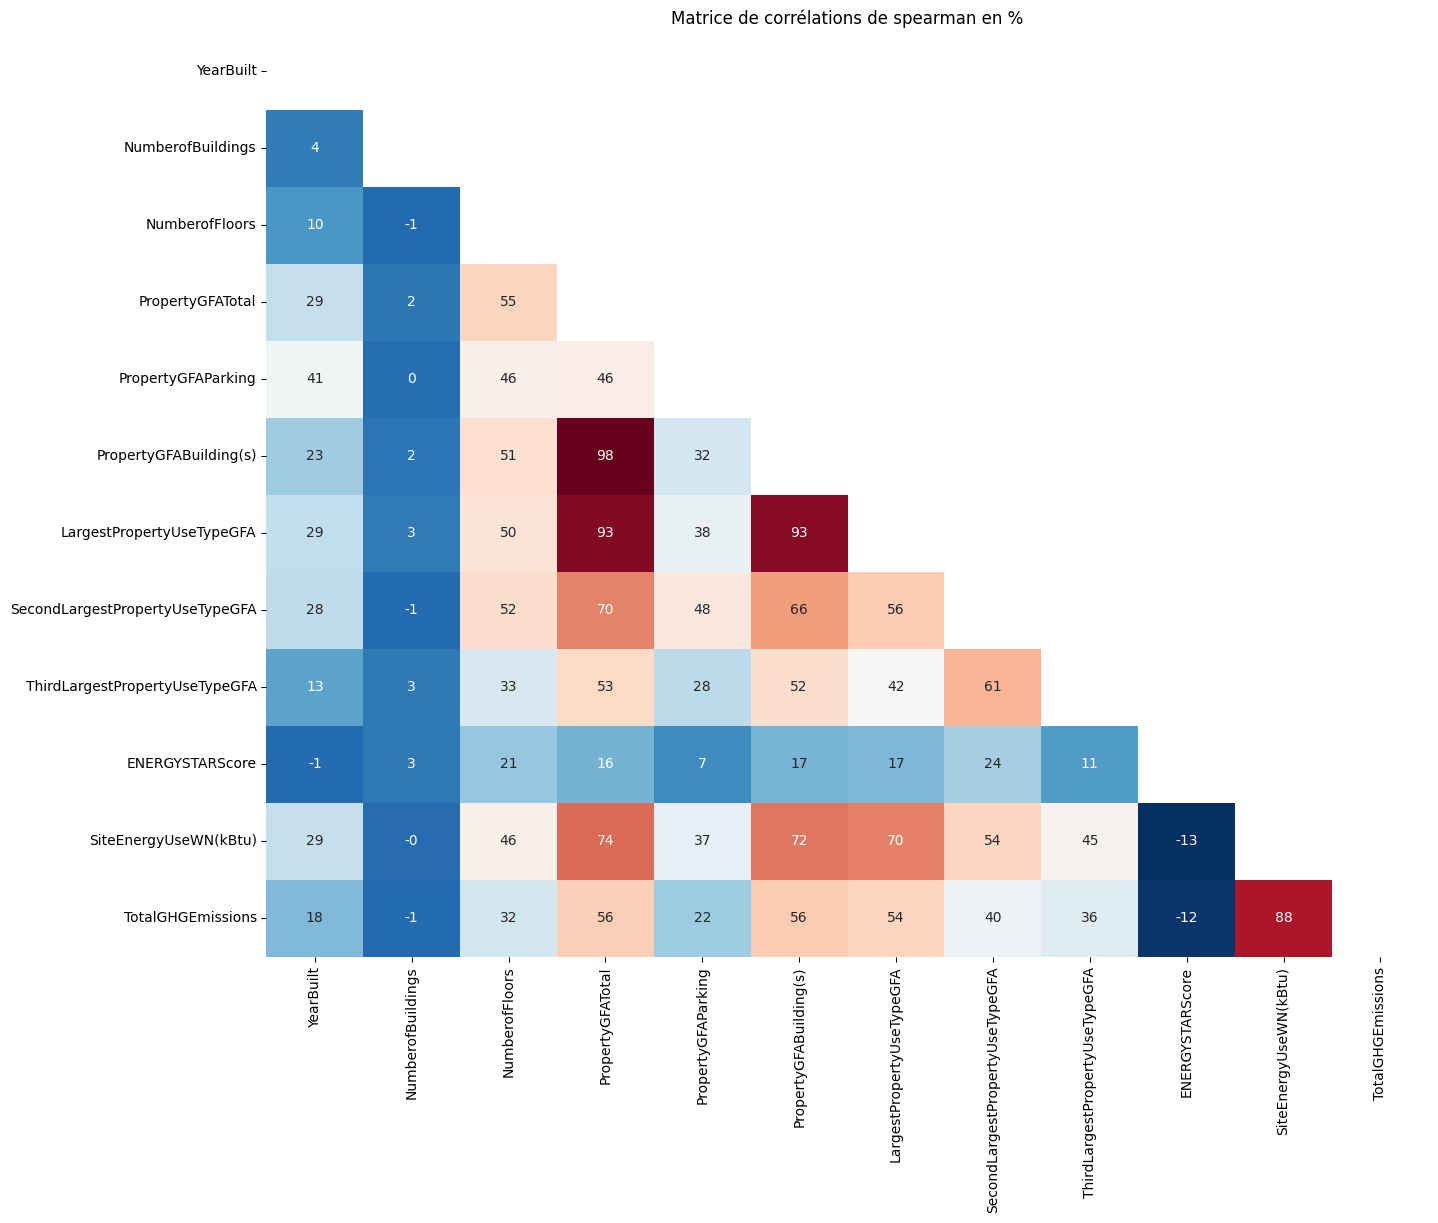

In [136]:
correlations(raw.drop(["OSEBuildingID", "CouncilDistrictCode", "Latitude", "Longitude"], axis=1), method="spearman")

La corrélation de Spearman permet d'évaluer la relation monotone entre deux variables continues ou ordinales. Test non paramétrique (on le garde avec les variables pas forcément normales).

- TotalEmissions et SiteEnergy très corrélées entre elles : il ne faudra pas utiliser l'une dans la prédiction de l'autre

- Les variables en GFA sont très corrélées entre elles, sauf GFAParking. Je conserve GFATotal et je supprime les variables qui lui sont corrélées à plus de 90%, puisqu'elle contient ces variables.

- A noter que la variable ENERGYSTARScore a des correlations négatives faibles avec les deux variables à prédire et des corrélations négatives moyennes avec les varibales de consommation d'énergie ramenées à l'unité de surface. Utiliser cette variable pour les prédictions semble faible à ce stade. Nous vérifierons cette hypothèse lors de l'entrainement des modèles

In [137]:
drop_cols = [
             "PropertyGFABuilding(s)",
             "LargestPropertyUseTypeGFA"
            ] 


raw = raw.drop(columns = drop_cols)
print(f"Nombre de variables restantes {raw.shape[1]}")

Nombre de variables restantes 21


## Construction de nouvelles variables.

### Calcul Distance par rapport au centre

In [138]:
# Take a central point in Seattle to calculate haversine
# Source : https://latitude.to/articles-by-country/us/united-states/17823/seattle-center
center_lat = 47.622451
center_long = -122.352033

raw["distance_from_center"] = [haversine(center_long, center_lat, Long, Lat) for Long, Lat in zip(raw["Longitude"], raw["Latitude"])]

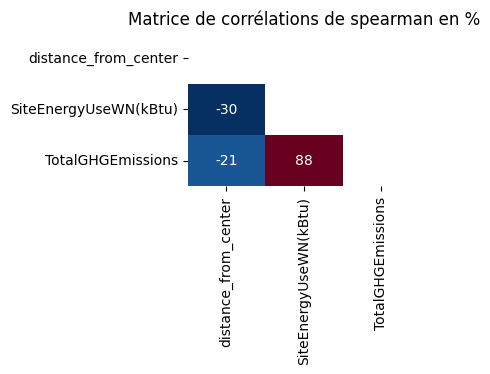

In [139]:
# Cette var est-elle corrélée aux var cibles ?
correlations_small(raw[["distance_from_center", "SiteEnergyUseWN(kBtu)", "TotalGHGEmissions"]], method="spearman")

La variable distance n'est pas corrélée aux variables cibles. On peut la garder.

In [140]:
# Suppression des var Longitude et Latitude
raw.drop(columns=["Latitude", "Longitude"], inplace=True)

### Création variable nombre d'usages

In [141]:
raw["nb_properties"] = [len(row.split()) for row in raw.ListOfAllPropertyUseTypes]
raw.drop(columns = "ListOfAllPropertyUseTypes", inplace=True)

### Transformation de l'âge des bâtiments

In [142]:
raw["age_building"] = dt.datetime.today().year - raw.YearBuilt
raw.drop(columns="YearBuilt", inplace=True)

### Transformation de la variable NumberofBuildings

Lors de l'exploration des données nous avons pu observer que la majorité des sites ne sont composés que d'un seul bâtiment. Nous remplaçons le nombre de bâtiments par une varibale binaire. Celle-ci indique s'il y a plus d'un bâtiment sur le site. Avant celà nous obsersons la répartition des sites entre ceux qui n'ont qu'un seul bâtiment et ceux qui en ont plusieurs.

In [143]:
display(raw["NumberofBuildings"].describe())
more_one_building = raw[raw["NumberofBuildings"]>1]
one_building = raw[raw["NumberofBuildings"]==1]
print(f"Nombre de sites composés d'un seul bâtiment: {one_building.shape[0]}")
print(f"Nombre de sites composés de plusieurs bâtiments: {more_one_building.shape[0]}")

count    1428.000000
mean        1.015406
std         0.444275
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         7.000000
Name: NumberofBuildings, dtype: float64

Nombre de sites composés d'un seul bâtiment: 1353
Nombre de sites composés de plusieurs bâtiments: 28


Le nombre de sites de plus d'un bâtiments est effectivement très faible. Nous remplaçons l'indicateur de nombre de bâtiments par une variable binaire.

In [144]:
raw["more_one_building"] = (raw["NumberofBuildings"]>1).astype(int)
raw.drop(columns="NumberofBuildings", inplace=True)
raw.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,distance_from_center,nb_properties,age_building,more_one_building
0,1,NonResidential,Hotel,7,DOWNTOWN,12,88434,0,Hotel,NaN,NaN,NaN,NaN,60.0,7456910.0,249.98,1.551518,1,96,0
1,2,NonResidential,Hotel,7,DOWNTOWN,11,103566,15064,Hotel,Parking,15064.0,Restaurant,4622.0,61.0,8664479.0,295.86,1.704745,3,27,0
2,3,NonResidential,Hotel,7,DOWNTOWN,41,956110,196718,Hotel,NaN,NaN,NaN,NaN,43.0,73937112.0,2089.28,1.410086,1,54,0
3,5,NonResidential,Hotel,7,DOWNTOWN,10,61320,0,Hotel,NaN,NaN,NaN,NaN,56.0,6946800.5,286.43,1.479624,1,97,0
4,8,NonResidential,Hotel,7,DOWNTOWN,18,175580,62000,Hotel,Parking,68009.0,Swimming Pool,0.0,75.0,14656503.0,505.01,1.298926,4,43,0


## Variables catégorielles

### Distribution des variables catégorielles en fonction des variables cibles

In [145]:
#  Neighborhood pose un pb de casse : certaines catégories sont en minuscules, d'autres en majuscules
raw.Neighborhood = [name.upper() for name in raw.Neighborhood]

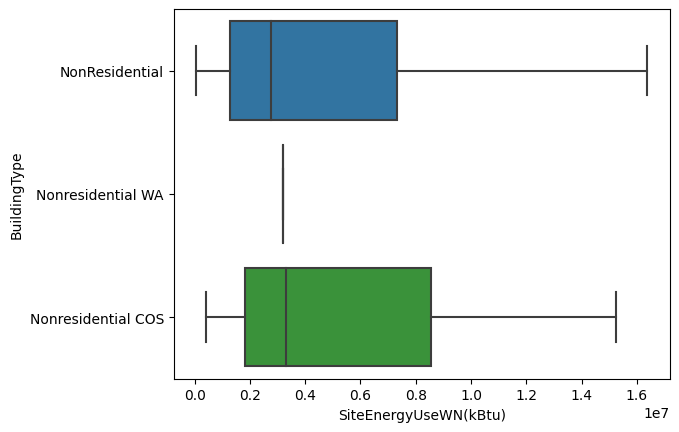

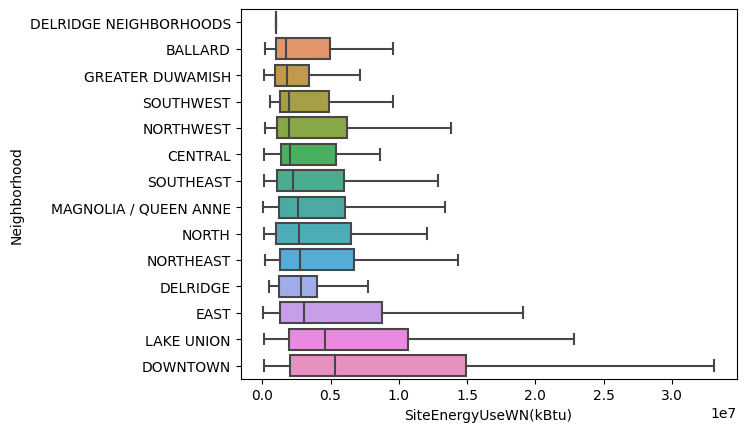

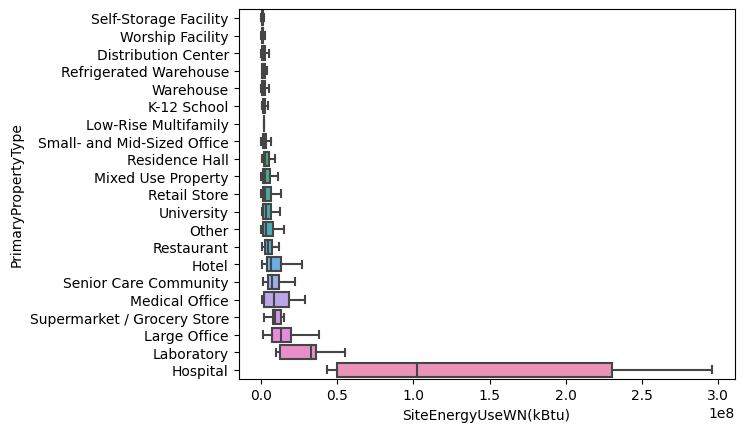

In [146]:
columns_categ = ["BuildingType"
                , "Neighborhood"
                ,"PrimaryPropertyType"
                ]


for col in columns_categ:
    var_cible = "SiteEnergyUseWN(kBtu)"
    grouped = raw.loc[:,[col, var_cible]].groupby(col).median().sort_values(by=var_cible)
    plt.subplots()
    temp = raw.groupby(col).mean()
    sns.boxplot(data=raw, x=var_cible, y = col, order=grouped.index, showfliers=False)
    plt.show()

- BuildingType n'est pas discriminant, on peut le supprimer.
- Neighborhood
    - contient des catégories au profil semblable, qu'on peut rassembler entre boxplots de même taille et même médianea
    - consommation faible ds qurtier Delridgde, forte dans l'Est et le Downtown, moyenne dans le centre, le Sud, le Nord 
- PrimaryPropertyType contient également des catégories au profil semblable, qu'on peut rassembler 
    - Hospital reste à part
    - Laboratory également
    - On peut rassembler les autres dans des catégories

In [147]:
raw.drop(columns="BuildingType", inplace=True)

In [148]:
conso_faible_neigb = ["GREATER DUWAMISH"
                , "DELRIDGE"
                , "DELRIDGE NEIGHBORHOODS"]
conso_moyenne_neigb = ["BALLARD"
                , "SOUTHWEST"
                , "NORTHWEST"
                , "CENTRAL"
                , "SOUTHEAST"
                , "MAGNOLIA / QUEEN ANNE"
                , "NORTH"
                , "NORTHEAST"
                ]
conso_forte_neigb = ["EAST"
                ,"LAKE UNION"
                ,"DOWNTOWN"   
                ]

In [149]:
raw.Neighborhood.replace(conso_faible_neigb, "low_cons", inplace=True)
raw.Neighborhood.replace(conso_moyenne_neigb, "med_cons", inplace=True)
raw.Neighborhood.replace(conso_forte_neigb, "high_cons", inplace=True)

<AxesSubplot:xlabel='SiteEnergyUseWN(kBtu)', ylabel='Neighborhood'>

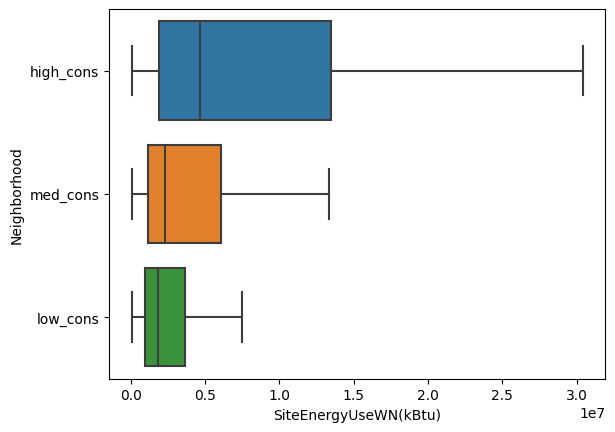

In [150]:
sns.boxplot(data=raw, x="SiteEnergyUseWN(kBtu)", y = "Neighborhood", showfliers=False)

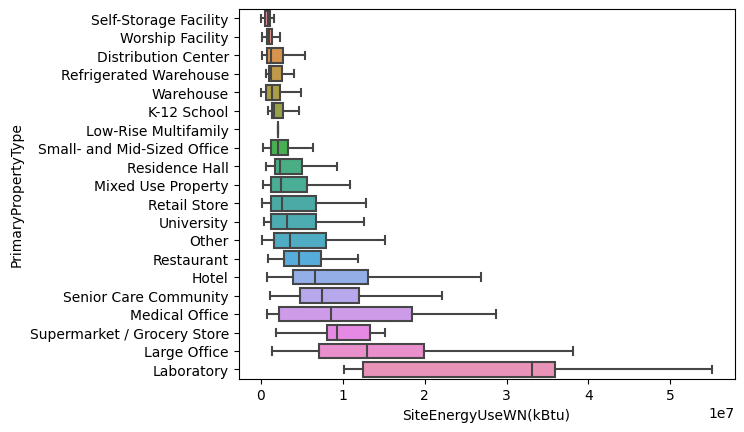

In [151]:
# Pour voir clair dans le boxplots PrimaryPropertyTYpe, on retire Hospital
grouped = raw.loc[raw["PrimaryPropertyType"] != "Hospital"]\
            .loc[:,["PrimaryPropertyType", var_cible]]\
                .groupby("PrimaryPropertyType").median().sort_values(by=var_cible)
plt.subplots()
temp = raw.groupby("PrimaryPropertyType").mean()
sns.boxplot(data=raw, x=var_cible, y = "PrimaryPropertyType", order=grouped.index, showfliers=False)
plt.show()

In [152]:
warehouse_storage_school = ['Self-Storage Facility', 'Worship Facility', 'Distribution Center',
       'Refrigerated Warehouse', 'Warehouse', 'K-12 School',
       'Low-Rise Multifamily']
store_restaurant_residence = ['Small- and Mid-Sized Office', 'Residence Hall',
       'Mixed Use Property', 'Retail Store', 'University', 'Other',
       'Restaurant'
                ]
hotel_office_supermarket = ['Hotel', 'Senior Care Community', 'Medical Office',
       'Supermarket / Grocery Store', 'Large Office' 
                ]
laboratory = "Laboratory"
hospital = "Hospital"

In [153]:
raw.PrimaryPropertyType.replace(warehouse_storage_school, "warehouse_storage_school", inplace=True)
raw.PrimaryPropertyType.replace(store_restaurant_residence, "store_restaurant_residence", inplace=True)
raw.PrimaryPropertyType.replace(hotel_office_supermarket, "hotel_office_supermarket", inplace=True)
raw.PrimaryPropertyType.replace(laboratory, "laboratory", inplace=True)
raw.PrimaryPropertyType.replace(hospital, "hospital", inplace=True)

<AxesSubplot:xlabel='SiteEnergyUseWN(kBtu)', ylabel='PrimaryPropertyType'>

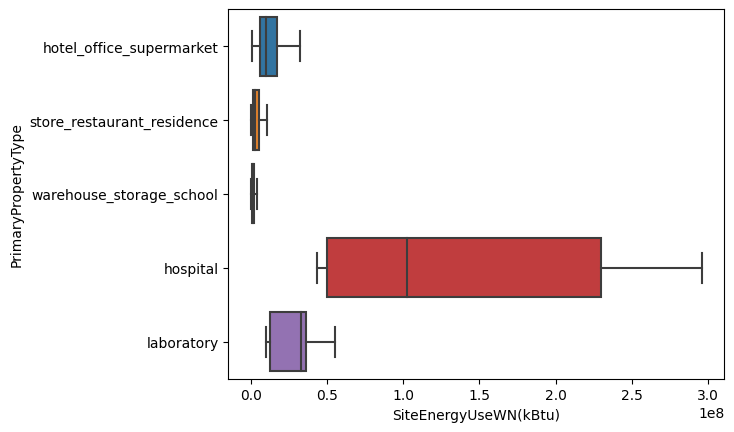

In [154]:
sns.boxplot(data=raw, x="SiteEnergyUseWN(kBtu)", y = "PrimaryPropertyType", showfliers=False)

In [155]:
# Get dummies
raw = pd.get_dummies(raw, columns = ["Neighborhood", "PrimaryPropertyType"])

Nous pouvons maintenant supprimer la colonne PrimaryPropertyType.  
Considérant que les autres colonnes PropertyType donnent des informations moins essentielles pour le modèle nous décidons de les supprimer.

In [156]:
raw.drop(columns=['LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'], inplace=True)

In [157]:
# Export
PATH_DATA_OUTPUT = '/Users/alexandremonod/Python/OC_ML/projet_3_anticiper_consommation_ges_seattle/data_output'
raw.to_pickle(f"{PATH_DATA_OUTPUT}/data_clean.pkl")